# Chains in LangChain

## Outline

* LLMChain
* Sequential Chains
  * SimpleSequentialChain
  * SequentialChain
* Router Chain

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
import os

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

In [2]:
llm_model = "gpt-3.5-turbo"

In [3]:
import pandas as pd
df = pd.read_csv('data.csv')

In [4]:
df.head()

,Product,Review
0,Queen Size Sheet Set,I ordered a king size set. My only criticism w...
1,Waterproof Phone Pouch,"I loved the waterproof sac, although the openi..."
2,Luxury Air Mattress,This mattress had a small hole in the top of i...
3,Pillows Insert,This is the best throw pillow fillers on Amazo...
4,Milk Frother Handheld\n,I loved this product. But they only seem to l...


## LLMChain

In [13]:
from langchain.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

In [9]:
llm = ChatOpenAI(temperature=0.9, model=llm_model)

In [10]:
prompt = ChatPromptTemplate.from_template(
    "What is the best name to describe \
    a company that makes {product}?"
)

In [12]:
chain = prompt | llm
product = "Queen Size Sheet Set"
response = chain.invoke(product)
print(response.content)

"Royal Slumber"


In [16]:
llm = ChatOpenAI(temperature=0.9, model=llm_model)

# prompt template 1
first_prompt = ChatPromptTemplate.from_template(
    "What is the best name to describe \
    a company that makes {product}?"
)

# prompt template 2
second_prompt = ChatPromptTemplate.from_template(
    "Write a 20 words description for the following \
    company:{company_name}"
)

overall_simple_chain = first_prompt | llm | second_prompt | llm
response = overall_simple_chain.invoke(product, verbose=True)
print(response.content)

Regal Beddings offers luxurious and elegant bedding solutions for a good night's sleep with unmatched comfort and quality.


## SequentialChain

Ported from legacy to LCEL

In [71]:
from langchain_core.runnables import RunnableAssign
from langchain.callbacks.tracers import ConsoleCallbackHandler
from operator import itemgetter

llm = ChatOpenAI(temperature=0.9, model=llm_model)

# prompt template 1: translate to english
first_prompt = ChatPromptTemplate.from_template(
    "Translate the following review to english:"
    "\n\n{review}"
)

# prompt template 2: summarize
second_prompt = ChatPromptTemplate.from_template(
    "Can you summarize the following review in 1 sentence:"
    "\n\n{english_review}"
)

# prompt template 3: translate to english
third_prompt = ChatPromptTemplate.from_template(
    "What language is the following review:\n\n{review}"
)

# prompt template 4: follow up message
fourth_prompt = ChatPromptTemplate.from_template(
    "Write a follow up response to the following "
    "summary in the specified language:"
    "\n\nSummary: {summary}\n\nLanguage: {language}"
)

english_summary_chain = first_prompt | llm | second_prompt | llm
original_language_chain = third_prompt | llm
follow_up_chain = fourth_prompt | llm

sequential_chain = (
    RunnableAssign({"summary": english_summary_chain, "review": itemgetter("review")})
    | RunnableAssign({"language": original_language_chain})
    | follow_up_chain
)

response = sequential_chain.invoke({"review": df.Review[5]}) #config={'callbacks': [ConsoleCallbackHandler()]})
print(response.content)

Merci de votre retour détaillé sur le produit. Nous sommes désolés d'apprendre que vous n'êtes pas satisfait de la qualité de notre produit. Nous prenons vos préoccupations au sérieux et nous allons enquêter sur la question de l'authenticité de notre produit. Veuillez nous contacter directement pour que nous puissions résoudre ce problème et vous offrir une expérience client positive. Merci encore pour vos commentaires.


## Router Chain

Ported from Legacy to LECL

In [2]:
physics_prompt = """You are a very smart physics professor. \
You are great at answering questions about physics in a concise\
and easy to understand manner. \
When you don't know the answer to a question you admit\
that you don't know.

Here is a question:
"""


math_prompt = """You are a very good mathematician. \
You are great at answering math questions. \
You are so good because you are able to break down \
hard problems into their component parts, 
answer the component parts, and then put them together\
to answer the broader question.

Here is a question:
"""

history_prompt = """You are a very good historian. \
You have an excellent knowledge of and understanding of people,\
events and contexts from a range of historical periods. \
You have the ability to think, reflect, debate, discuss and \
evaluate the past. You have a respect for historical evidence\
and the ability to make use of it to support your explanations \
and judgements.

Here is a question:
"""


computerscience_prompt = """ You are a successful computer scientist.\
You have a passion for creativity, collaboration,\
forward-thinking, confidence, strong problem-solving capabilities,\
understanding of theories and algorithms, and excellent communication \
skills. You are great at answering coding questions. \
You are so good because you know how to solve a problem by \
describing the solution in imperative steps \
that a machine can easily interpret and you know how to \
choose a solution that has a good balance between \
time complexity and space complexity. 

Here is a question:
"""

In [3]:
prompt_infos = [
    {
        "name": "physics",
        "description": "Good for answering questions about physics", 
        "prompt": physics_prompt
    },
    {
        "name": "math",
        "description": "Good for answering math questions", 
        "prompt": math_prompt
    },
    {
        "name": "history",
        "description": "Good for answering history questions", 
        "prompt": history_prompt
    },
    {
        "name": "computer science",
        "description": "Good for answering computer science questions", 
        "prompt": computerscience_prompt
    }
]

In [4]:
from langchain_openai import ChatOpenAI

llm_model = "gpt-4o-mini"
llm = ChatOpenAI(temperature=0, model=llm_model)

In [5]:
from langchain.prompts import ChatPromptTemplate

destination_chains = {}
for p_info in prompt_infos:
    name = p_info["name"]
    system_prompt = p_info["prompt"]
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            ("human", "{input}")
        ]
    )
    chain = prompt | llm
    destination_chains[name] = chain  
    
destinations = [f"{p['name']}: {p['description']}" for p in prompt_infos]
destinations_str = "\n".join(destinations)

In [6]:
default_prompt = ChatPromptTemplate.from_template("{input}")
default_chain = default_prompt | llm

In [7]:
from typing import Literal
from typing_extensions import TypedDict

route_system = f"""Route to one of the experts mentioned below based on the user's question \
If none of the experts are appropriate, route to "default".

<< CANDIDATE EXPERTS >>
{destinations_str}"""
router_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", route_system),
        ("human", "{input}")
    ]
)

class RouteQuery(TypedDict):
    destination: Literal["physics", "math", "history", "computer_science", "default"]

route_chain = router_prompt | llm.with_structured_output(RouteQuery)

In [30]:
from langchain_core.runnables import RunnableConfig
from langgraph.graph import END, START, StateGraph

# For LangGraph, we will define the state of the graph to hold the query,
# destination, and final answer.
class State(TypedDict):
    query: str
    destination: RouteQuery
    answer: str


node_name_to_function = {}
for p_info in prompt_infos:
    name = p_info["name"]
    chain = destination_chains[name]

    async def node_fn(state: State, config: RunnableConfig):
        answer = await chain.ainvoke(state["query"], config)
        return {"answer": answer.content}
    
    node_name_to_function[name] = node_fn

async def default_prompt(state: State, config: RunnableConfig):
    answer = await default_chain.ainvoke(state["query"], config)
    return {"answer": answer.content}

async def route_query(state: State, config: RunnableConfig):
    route_response = await route_chain.ainvoke(state["query"], config)
    return {"destination": route_response["destination"]}


def select_node(state: State) -> Literal["physics", "math", "history", "computer science", "default"]:
    if state["destination"] == "default":
        return "default"
    for p_info in prompt_infos:
        if state["destination"] == p_info["name"]:
            return p_info["name"]
        

graph = StateGraph(State)
graph.add_node("route_query", route_query)
for p_info in prompt_infos:
    graph.add_node(p_info["name"], node_name_to_function[p_info["name"]])

graph.add_node("default", default_prompt)

graph.add_edge(START, "route_query")
graph.add_conditional_edges("route_query", select_node)
for p_info in prompt_infos:
    graph.add_edge(p_info["name"], END)
graph.add_edge("default", END)
app = graph.compile()


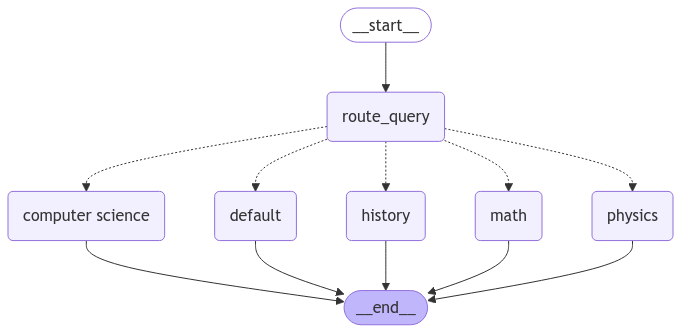

In [31]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

In [32]:
query = "What is black body radiation?"
state = await app.ainvoke({"query": query})
print(state["destination"])
print(state["answer"])

physics
Black body radiation refers to the electromagnetic radiation emitted by an idealized physical body known as a "black body" when it is in thermal equilibrium. A black body is an idealized object that absorbs all incident radiation, regardless of frequency or angle of incidence, and re-emits energy in a characteristic spectrum that depends solely on its temperature.

### Key Concepts:

1. **Black Body**: An idealized object that perfectly absorbs all incoming radiation and emits radiation in a continuous spectrum.

2. **Thermal Equilibrium**: A state where the body is at a uniform temperature and the energy absorbed equals the energy emitted.

3. **Planck's Law**: Describes the spectral density of electromagnetic radiation emitted by a black body in thermal equilibrium at a given temperature. It shows that the intensity of radiation emitted varies with wavelength and temperature.

4. **Wien's Displacement Law**: States that the wavelength at which the emission of radiation is max

In [33]:
query = "what is 2 + 2"
state = await app.ainvoke({"query": query})
print(state["destination"])
print(state["answer"])

math
The sum of 2 + 2 is 4.


In [34]:
query = "Why does every cell in our body contain DNA?"
state = await app.ainvoke({"query": query})
print(state["destination"])
print(state["answer"])

default
Every cell in our body contains DNA because DNA serves as the genetic blueprint for the organism. Here are several key reasons why this is the case:

1. **Genetic Information**: DNA contains the instructions needed for the development, functioning, growth, and reproduction of all living organisms. It encodes the information necessary to produce proteins, which perform a vast array of functions in the body.

2. **Cellular Function**: Each cell type in the body has specific functions, and the DNA in each cell contains the genes that are necessary for that cell's role. For example, muscle cells have genes that help them contract, while nerve cells have genes that support their ability to transmit signals.

3. **Development and Differentiation**: During the development of an organism, all cells originate from a single fertilized egg. As the organism grows, cells divide and differentiate into various types, but they all retain the same DNA. This ensures that all cells have the compl